In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess the images
def load_and_process_image(image_path):
    img = load_img(image_path, target_size=(400, 400))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [3]:
def deprocess_image(img):
    img = img.reshape((400, 400, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [4]:
content_image_path = '/content/persian-cat.jpg'
style_image_path = '/content/style img.jpg'
content_image = load_and_process_image(content_image_path)
style_image = load_and_process_image(style_image_path)

In [5]:
# Load the VGG19 model
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

80134624/80134624 [==============================] - 4s 0us/step


In [6]:
# Content layer and style layers
content_layer = 'block5_conv2'
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

In [7]:
# Create models for content and style
content_model = Model(inputs=vgg.input, outputs=vgg.get_layer(content_layer).output)
style_models = [Model(inputs=vgg.input, outputs=vgg.get_layer(layer).output) for layer in style_layers]

In [8]:
# Gram matrix function
def gram_matrix(x):
    x = tf.squeeze(x, axis=0)
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [9]:
# Compute total loss
def compute_loss(combination_image, content_image, style_image):
    content_output = content_model(combination_image)
    content_loss = tf.reduce_mean(tf.square(content_output - content_model(content_image)))

    style_loss = 0
    for style_model in style_models:
        style_output = style_model(combination_image)
        style_gram = gram_matrix(style_model(style_image))
        combination_gram = gram_matrix(style_output)
        size = tf.size(style_model(style_image))
        style_loss += tf.reduce_mean(tf.square(style_gram - combination_gram)) / tf.cast(size, tf.float32)

    total_loss = content_loss + 1e-5 * style_loss
    return total_loss

In [10]:
# Train the model
combination_image = tf.Variable(content_image, dtype=tf.float32)

In [11]:
optimizer = Adam(learning_rate=10.0)

In [12]:
@tf.function
def train_step(combination_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, content_image, style_image)
    grads = tape.gradient(loss, combination_image)
    optimizer.apply_gradients([(grads, combination_image)])
    return loss

Epoch 0


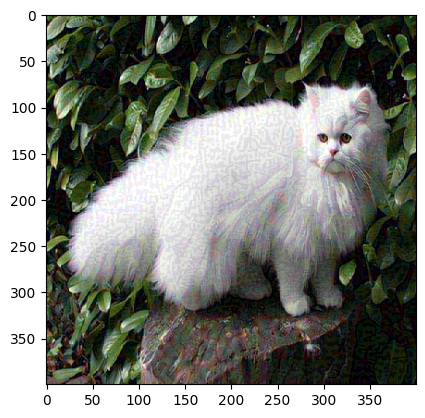

Epoch 100


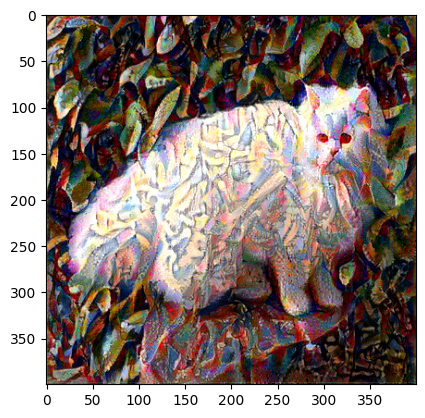

Epoch 200


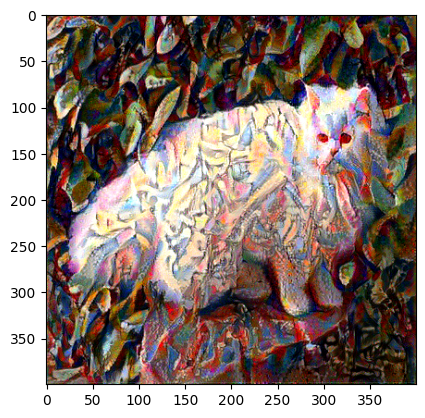

Epoch 300


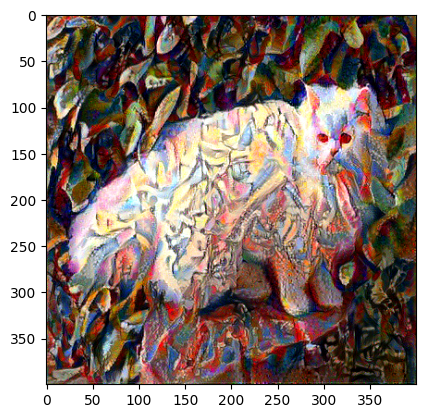

Epoch 400


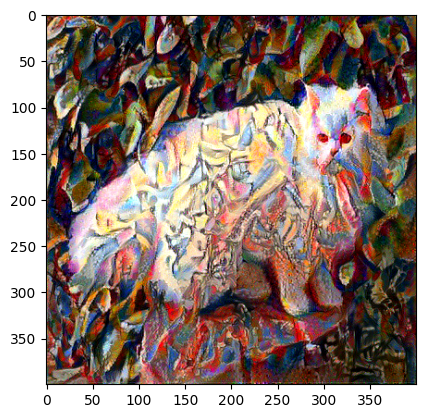

Epoch 500


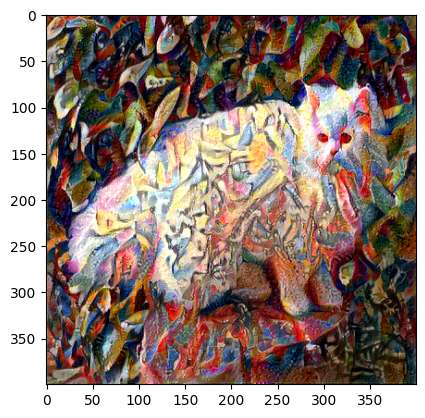

Epoch 600


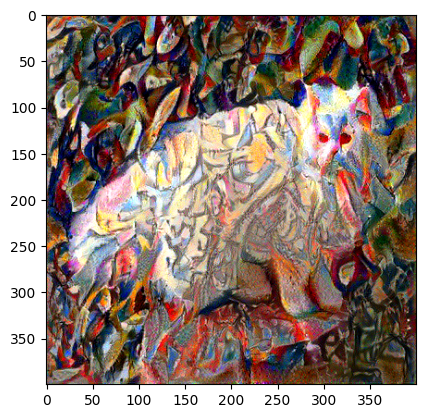

Epoch 700


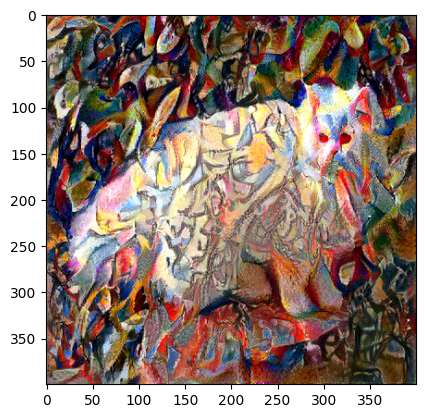

Epoch 800


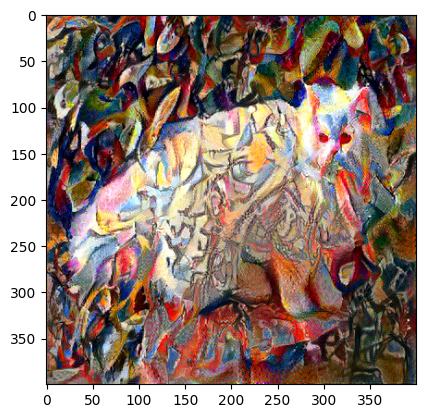

Epoch 900


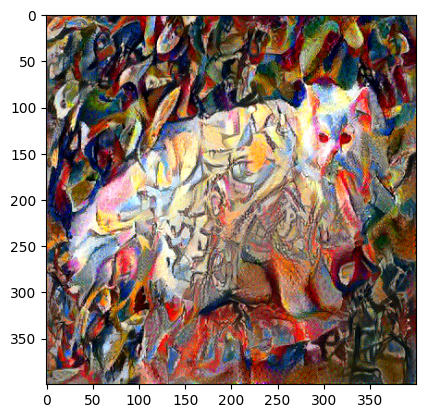

In [13]:
epochs = 1000
for i in range(epochs):
    loss = train_step(combination_image)
    if i % 100 == 0:
        print(f'Epoch {i}')
        output_image = deprocess_image(combination_image.numpy())
        plt.imshow(output_image)
        plt.show()

In [14]:
# Save the final image
final_image = deprocess_image(combination_image.numpy())
plt.imsave('output_image.jpg', final_image)